In [6]:
import os
from PIL import Image
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dir='/content/drive/MyDrive/FruitinAmazon/FruitinAmazon/train'
class_names = sorted(os.listdir(train_dir))
if not class_names:
  print("No class directories found in the train folder!")
else:
  print(f"Found {len(class_names)} classes: {class_names}")

Found 6 classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


Checking for couroupted image


In [4]:
from PIL import Image, UnidentifiedImageError

corrupted_images = [] # List to store corrupted images path

# Loop through each class folder and check for corrupted images
for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path): # Ensure it’s a valid directory
    images = os.listdir(class_path)
    for img_name in images:
      img_path = os.path.join(class_path, img_name)
      try:
        with Image.open(img_path) as img:
          img.verify() # Verify image integrity
      except (IOError, UnidentifiedImageError):
        corrupted_images.append(img_path)
# Print results
if corrupted_images:
  print("\nCorrupted Images Found:")
  for img in corrupted_images:
    print(img)
else:
  print("\nNo corrupted images found.")


No corrupted images found.


Class Imbalance Checking

In [5]:
# Dictionary to store class counts
class_counts = {}
for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path):
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    class_counts[class_name] = len(images) # Count images in each class

# Print Class Balance
print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
  print(f"{class_name:<25}{count:>15}")
print("=" * 45)


Class Distribution:
Class Name               Valid Image Count
acai                                  15
cupuacu                               15
graviola                              15
guarana                               15
pupunha                               15
tucuma                                15


Select Random Images for Visualization:

In [7]:
import random
selected_images = [] # Store image paths
selected_labels = [] # Store corresponding class names

for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path):
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if images: # Ensure the class folder is not empty
      selected_img = os.path.join(class_path, random.choice(images))
      selected_images.append(selected_img)
      selected_labels.append(class_name)

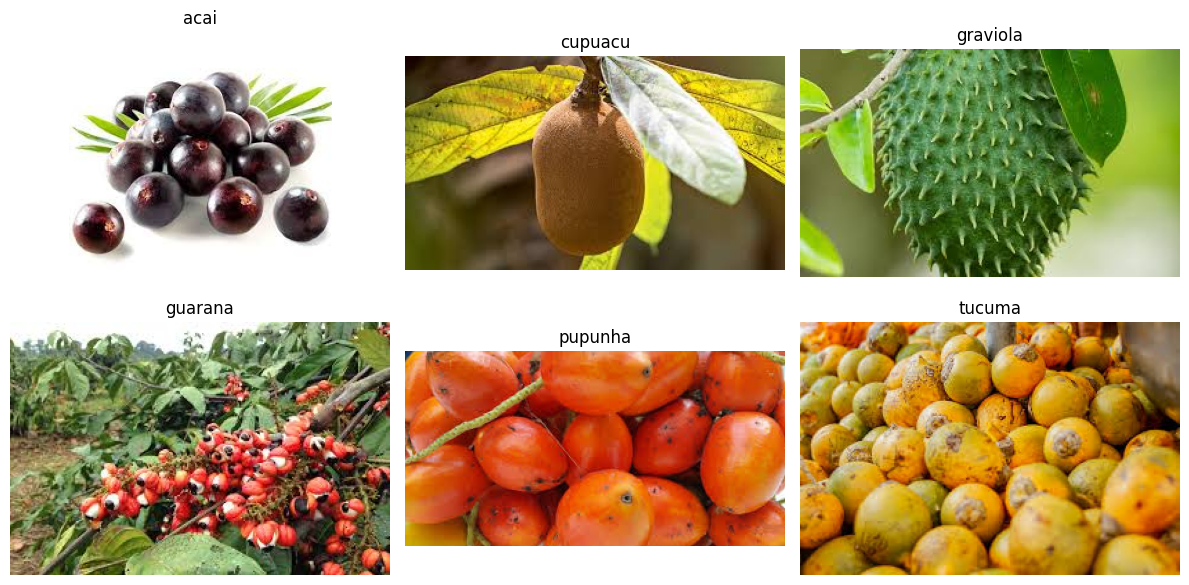

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Determine grid size
num_classes = len(selected_images)
cols = (num_classes + 1) // 2 # Determine columns
rows = 2 # Fixed rows for layout
fig, axes = plt.subplots(rows, cols, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
  if i < num_classes:
    img = mpimg.imread(selected_images[i])
    ax.imshow(img)
    ax.set_title(selected_labels[i])
    ax.axis("off")
  else:
    ax.axis("off") # Hide empty subplots

plt.tight_layout()
plt.show()

Data Generation and Pre - processing:

In [9]:


image_size = (28, 28)
batch_size = 32
train_ds, val_ds = keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="both",
  seed=1337,
  image_size=image_size,
  batch_size=batch_size,
)

Found 90 files belonging to 6 classes.
Using 72 files for training.
Using 18 files for validation.


In [10]:
for images, labels in train_ds.take(1): # Take one batch
  print("Images shape:", images.shape)
  print("Labels shape:", labels.shape)

Images shape: (32, 28, 28, 3)
Labels shape: (32,)


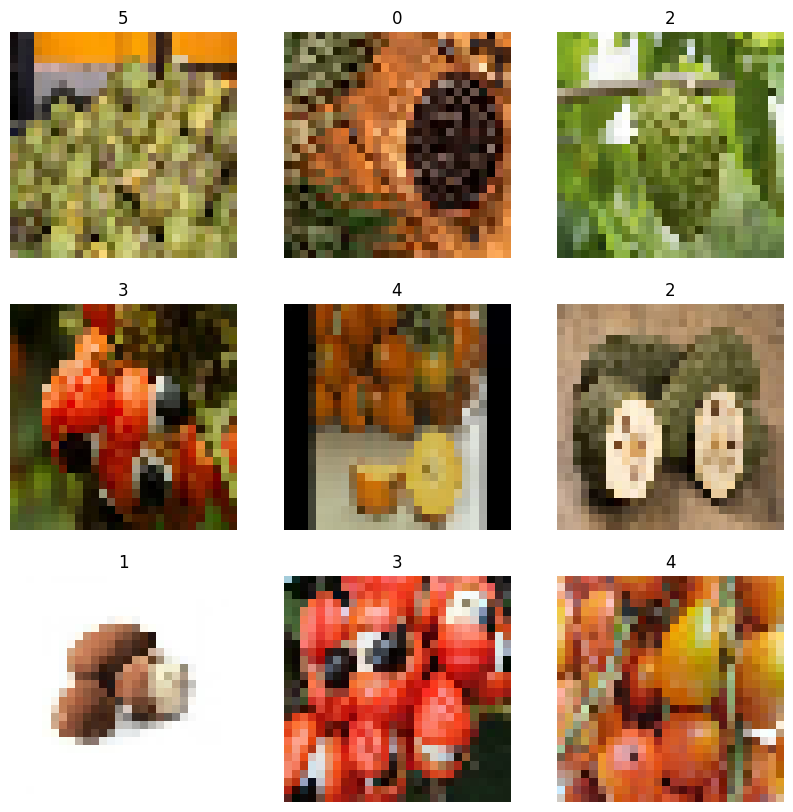

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
 for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(np.array(images[i]).astype("uint8"))
  plt.title(int(labels[i]))
  plt.axis("off")

Using Keras ImageDataGenerator (Old API):

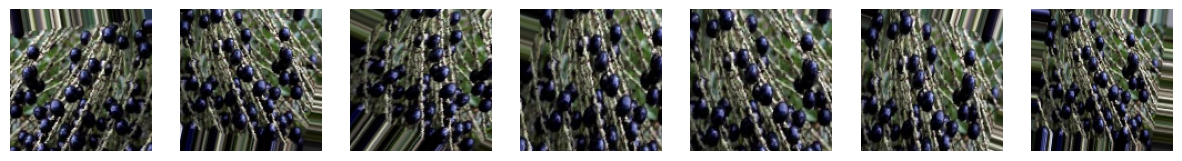

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Initialize ImageDataGenerator with augmentations
datagen = ImageDataGenerator(
    rotation_range=30,  # Rotate images by up to 30 degrees
    width_shift_range=0.2,  # Shift width by 20%
    height_shift_range=0.2,  # Shift height by 20%
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom in/out by 20%
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill in missing pixels
)
image_direct ='/content/drive/MyDrive/FruitinAmazon/FruitinAmazon/train/acai/images (12).jpeg'

# Load an example image
img = image.load_img(image_direct, target_size=(128, 128))
x = image.img_to_array(img)  # Convert to NumPy array
x = np.expand_dims(x, axis=0)  # Add an extra dimension for batch size

# Generate augmented images
aug_iter = datagen.flow(x, batch_size=1)

# Visualize 7 augmented images
fig, ax = plt.subplots(1, 7, figsize=(15, 5))
for i in range(7):
    batch = next(aug_iter)
    ax[i].imshow(batch[0].astype('uint8'))  # Display the image
    ax[i].axis('off')  # Hide axes

plt.show()


Using Keras tf.keras.layers.Random* (New API):

In [19]:


# Define augmentation layers
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),  # Random horizontal flip
    layers.RandomRotation(0.1),       # Random rotation up to 10%
]

# Define the data augmentation function
def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)  # Apply each augmentation layer
    return images


DataAugemntation Layer directly in Model.

In [27]:
input_shape = (128, 128, 3)

In [28]:

model = keras.Sequential([
layers.Input(shape=input_shape),
*data_augmentation_layers, # Include augmentation before the model layers
layers.Conv2D(32, (3,3), activation="relu"),
layers.MaxPooling2D(),
layers.Flatten(),
layers.Dense(10, activation="softmax")
])

Visualizing augemented Image.

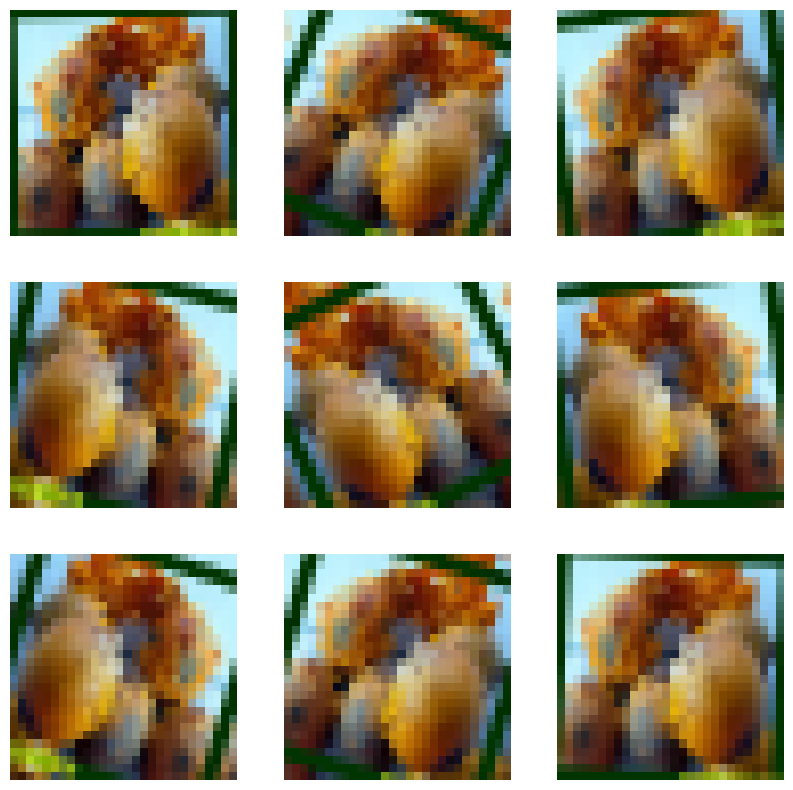

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
 for i in range(9):
  augmented_images = data_augmentation(images)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(np.array(augmented_images[0]).astype("uint8"))
  plt.axis("off")

Data Pre - processing: Scaling the data with Keras:

In [23]:
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

Make it part of the Model {Recommended Practice}:

In [29]:
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

Model Building:

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.1514 - loss: 22.9400 - val_accuracy: 0.1667 - val_loss: 36.5219
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.2762 - loss: 27.5984 - val_accuracy: 0.2667 - val_loss: 15.7363
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.2746 - loss: 12.3310 - val_accuracy: 0.2667 - val_loss: 4.0237
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.2567 - loss: 4.6125 - val_accuracy: 0.3222 - val_loss: 4.6824
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 0.3017 - loss: 4.6617 - val_accuracy: 0.3667 - val_loss: 3.2252
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.4109 - loss: 2.7242 - val_accuracy: 0.5222 - val_loss: 1.2624
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - accuracy: 0.5179 - loss: 1.3107 - val_accuracy: 0.4778 - val_loss: 1.5059
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.4515 - loss: 1.4667 - val_accuracy: 0.5667 - val_

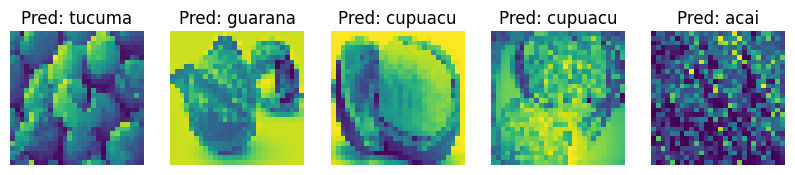

In [33]:

model = keras.Sequential([
  layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation="relu"),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(128, activation="relu"),
  layers.Dense(10, activation="softmax") # 10 classes for MNIST digits
])

# Compile the model
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

# Train the model
model.fit(train_ds, epochs=20, batch_size=32, validation_data=val_ds)
# Evaluate the model
test_loss, test_acc = model.evaluate(train_ds)
print(f"Test accuracy: {test_acc:.4f}")
# Make predictions
# predictions = model.predict(x_test[:5])
# predicted_labels = np.argmax(predictions, axis=1)
# print("Predicted labels:", predicted_labels)

# Get the class names from the dataset
class_names = val_ds.class_names

# Make predictions and print class names
for images, labels in val_ds.take(1):  # Take one batch from the validation dataset
    predictions = model.predict(images[:5])  # Predict for the first 5 images
    predicted_labels = np.argmax(predictions, axis=1)  # Get the index of the highest probability for each image

    # Print predicted class names
    print("Predicted class names:")
    for label in predicted_labels:
        print(class_names[label])  # Print the class name instead of the label number

    # Optionally, show the images with their predictions
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Pred: {class_names[predicted_labels[i]]}")
        plt.axis("off")
    plt.show()

BatchNormalization Class in Keras:

In [38]:
data_augmentation_layers = [
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
]

In [39]:
def data_augmentation(images):
  for layer in data_augmentation_layers:
    images = layer(images)
  return images

In [40]:
from tensorflow.keras import layers, Sequential

model = Sequential([
    # Data augmentation applied using Lambda layer
    layers.Lambda(data_augmentation, input_shape=(224, 224, 3)),
    # Rescaling layer to normalize pixel values
    layers.Rescaling(1./255),
    # First Convolutional Block
    layers.Conv2D(32, (3, 3), padding='same', activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), padding='same', activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), padding='same', activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    # Fourth Convolutional Block
    layers.Conv2D(256, (3, 3), padding='same', activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    # Flatten the output of the last Conv2D layer
    layers.Flatten(),
    # First Fully Connected Layer
    layers.Dense(512, activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    # Second Fully Connected Layer
    layers.Dense(256, activation=None),
     layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    # Third Fully Connected Layer
    layers.Dense(128, activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    # Fourth Fully Connected Layer
    layers.Dense(64, activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    # Output Layer with 10 neurons (for classification task with 10 classes)
    layers.Dense(10, activation='softmax')
])

# Compile the model with Adam optimizer, sparse categorical crossentropy loss, and accuracy as the metric
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 50176)          │             

 Total params: 26,257,930 (100.17 MB)

 Trainable params: 26,255,050 (100.16 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [42]:
from tensorflow.keras.applications import VGG16
# Load the VGG16 model pre-trained on ImageNet, without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [44]:
# Freeze the layers of the base model
for layer in base_model.layers:
  layer.trainable = False

In [45]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# Add custom layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x) # Reduces dimensions (height, width) to a single vector per image
x = Dense(1024, activation='relu')(x) # Fully connected layer with 1024 neurons
x = Dense(10, activation='softmax')(x) # Output layer for 10 classes (with softmax for multi-classclassification)

In [46]:
from tensorflow.keras.models import Model
# Create the final model
model = Model(inputs=base_model.input, outputs=x)

In [47]:
from tensorflow.keras.optimizers import Adam
# Compile the model

train_ds, val_ds = keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="both",
  seed=1337,
  image_size=(224,224),
  batch_size=32,
)
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_ds, epochs=5, validation_data=val_ds)

Found 90 files belonging to 6 classes.
Using 72 files for training.
Using 18 files for validation.
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 14s/step - accuracy: 0.0898 - loss: 8.0044 - val_accuracy: 0.1667 - val_loss: 5.2007
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 40s 13s/step - accuracy: 0.4822 - loss: 2.6378 - val_accuracy: 0.3889 - val_loss: 2.5302
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 39s 12s/step - accuracy: 0.9440 - loss: 0.1289 - val_accuracy: 0.5000 - val_loss: 3.6730
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 14s/step - accuracy: 0.9488 - loss: 0.2660 - val_accuracy: 0.3889 - val_loss: 6.8680
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 82s 13s/step - accuracy: 0.8928 - loss: 0.5141 - val_accuracy: 0.4444 - val_loss: 7.3290


In [48]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,321,376 (62.26 MB)

 Trainable params: 535,562 (2.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 1,071,126 (4.09 MB)